In [1]:
from acquire import get_zillow_data
from wrangle_zillow import wrangle_zillow, train_validate_test, Min_Max_Scaler
import matplotlib.pyplot as plt
import seaborn as sns

### Acquire and examine the data

Acquire the data from the zillow database ('Single Family Residential' properties from 2017)



In [2]:
df = get_zillow_data()

In [3]:
df

,propertylandusetypeid,transactiondate,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount
0,261.0,2017-07-21,1316.0,3.0,2.0,205123.0,2627.48
1,261.0,2017-06-23,1458.0,3.0,2.0,136104.0,2319.90
2,261.0,2017-06-30,1421.0,2.0,1.0,35606.0,543.69
3,261.0,2017-06-01,2541.0,4.0,3.0,880456.0,9819.72
4,261.0,2017-08-23,1491.0,3.0,2.0,107110.0,1399.27
...,...,...,...,...,...,...,...
28414,261.0,2017-08-31,1187.0,4.0,1.5,465999.0,5552.68
28415,261.0,2017-08-31,3015.0,5.0,3.0,852813.0,11662.88
28416,261.0,2017-08-31,2992.0,5.0,3.0,1120000.0,13663.03
28417,261.0,2017-08-31,1574.0,3.0,3.0,563463.0,6903.66


In [4]:
df.isnull().sum()

propertylandusetypeid            0
transactiondate                  0
calculatedfinishedsquarefeet    73
bedroomcnt                       0
bathroomcnt                      0
taxvaluedollarcnt                1
taxamount                        1
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28419 entries, 0 to 28418
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         28419 non-null  float64
 1   transactiondate               28419 non-null  object 
 2   calculatedfinishedsquarefeet  28346 non-null  float64
 3   bedroomcnt                    28419 non-null  float64
 4   bathroomcnt                   28419 non-null  float64
 5   taxvaluedollarcnt             28418 non-null  float64
 6   taxamount                     28418 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.5+ MB


In [6]:
df.shape

(28419, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28419 entries, 0 to 28418
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         28419 non-null  float64
 1   transactiondate               28419 non-null  object 
 2   calculatedfinishedsquarefeet  28346 non-null  float64
 3   bedroomcnt                    28419 non-null  float64
 4   bathroomcnt                   28419 non-null  float64
 5   taxvaluedollarcnt             28418 non-null  float64
 6   taxamount                     28418 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.5+ MB


In [8]:
# Rename the columns into something more readable
df = df.rename(columns={'propertylandusetypeid': 'land_use_typeid', 'bathroomcnt': 'num_bathrooms', 'bedroomcnt': 'num_bedrooms',
                       'calculatedfinishedsquarefeet': 'square_feet', 'taxvaluedollarcnt': 'appraised_value', 'taxamount': 'taxes'})

In [9]:
df.square_feet.describe()

count    28346.000000
mean      1931.750194
std       1013.652864
min        240.000000
25%       1276.000000
50%       1669.000000
75%       2319.000000
max      35640.000000
Name: square_feet, dtype: float64

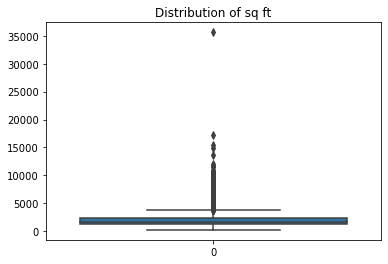

In [10]:
sns.boxplot(data=df.square_feet)
plt.title('Distribution of sq ft')
plt.show()

In [11]:
# remove outliers from calculatedfinishedsquarefeet
# calculate 1QR and 3QR
q1, q3 = df.square_feet.quantile([0.25, 0.75])
q1, q3

(1276.0, 2319.0)

In [12]:
# calculate IQR
iqr = q3 - q1
iqr

1043.0

In [13]:
# calculate upper and lower bounds
upper = q3 + (1.5 * iqr)
lower = q1 - (1.5 * iqr)
upper, lower

(3883.5, -288.5)

In [14]:
df = df[(df.square_feet > lower) & (df.square_feet < upper)]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27133 entries, 0 to 28418
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   land_use_typeid  27133 non-null  float64
 1   transactiondate  27133 non-null  object 
 2   square_feet      27133 non-null  float64
 3   num_bedrooms     27133 non-null  float64
 4   num_bathrooms    27133 non-null  float64
 5   appraised_value  27132 non-null  float64
 6   taxes            27132 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.7+ MB


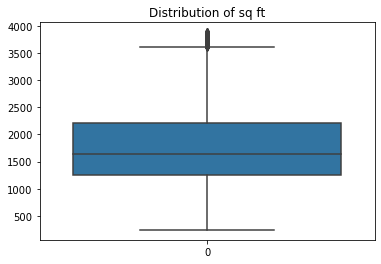

In [16]:
# Plot with outliers removed
sns.boxplot(data=df.square_feet)
plt.title('Distribution of sq ft')
plt.show()

### Prep the data

In [17]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [18]:
# drop null values
df.dropna(axis=0, inplace=True)

In [19]:
df.shape

(27131, 7)

In [20]:
df

,land_use_typeid,transactiondate,square_feet,num_bedrooms,num_bathrooms,appraised_value,taxes
0,261.0,2017-07-21,1316.0,3.0,2.0,205123.0,2627.48
1,261.0,2017-06-23,1458.0,3.0,2.0,136104.0,2319.90
2,261.0,2017-06-30,1421.0,2.0,1.0,35606.0,543.69
3,261.0,2017-06-01,2541.0,4.0,3.0,880456.0,9819.72
4,261.0,2017-08-23,1491.0,3.0,2.0,107110.0,1399.27
...,...,...,...,...,...,...,...
28414,261.0,2017-08-31,1187.0,4.0,1.5,465999.0,5552.68
28415,261.0,2017-08-31,3015.0,5.0,3.0,852813.0,11662.88
28416,261.0,2017-08-31,2992.0,5.0,3.0,1120000.0,13663.03
28417,261.0,2017-08-31,1574.0,3.0,3.0,563463.0,6903.66


In [21]:
#Make sure the nulls have been removed.
df.isna().sum()

land_use_typeid    0
transactiondate    0
square_feet        0
num_bedrooms       0
num_bathrooms      0
appraised_value    0
taxes              0
dtype: int64

In [22]:
df

,land_use_typeid,transactiondate,square_feet,num_bedrooms,num_bathrooms,appraised_value,taxes
0,261.0,2017-07-21,1316.0,3.0,2.0,205123.0,2627.48
1,261.0,2017-06-23,1458.0,3.0,2.0,136104.0,2319.90
2,261.0,2017-06-30,1421.0,2.0,1.0,35606.0,543.69
3,261.0,2017-06-01,2541.0,4.0,3.0,880456.0,9819.72
4,261.0,2017-08-23,1491.0,3.0,2.0,107110.0,1399.27
...,...,...,...,...,...,...,...
28414,261.0,2017-08-31,1187.0,4.0,1.5,465999.0,5552.68
28415,261.0,2017-08-31,3015.0,5.0,3.0,852813.0,11662.88
28416,261.0,2017-08-31,2992.0,5.0,3.0,1120000.0,13663.03
28417,261.0,2017-08-31,1574.0,3.0,3.0,563463.0,6903.66


In [23]:
df.transactiondate.value_counts(dropna=False, ascending=True)

2017-07-16      1
2018-05-25      1
2017-06-03      1
2017-08-13      1
2017-07-09      1
             ... 
2017-05-26    491
2017-08-31    505
2017-07-28    536
2017-05-31    549
2017-06-30    783
Name: transactiondate, Length: 120, dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27131 entries, 0 to 28418
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   land_use_typeid  27131 non-null  float64
 1   transactiondate  27131 non-null  object 
 2   square_feet      27131 non-null  float64
 3   num_bedrooms     27131 non-null  float64
 4   num_bathrooms    27131 non-null  float64
 5   appraised_value  27131 non-null  float64
 6   taxes            27131 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.7+ MB


In [25]:
df1 = df.drop(columns=['transactiondate', 'land_use_typeid', 'taxes'])

In [26]:
df1


,square_feet,num_bedrooms,num_bathrooms,appraised_value
0,1316.0,3.0,2.0,205123.0
1,1458.0,3.0,2.0,136104.0
2,1421.0,2.0,1.0,35606.0
3,2541.0,4.0,3.0,880456.0
4,1491.0,3.0,2.0,107110.0
...,...,...,...,...
28414,1187.0,4.0,1.5,465999.0
28415,3015.0,5.0,3.0,852813.0
28416,2992.0,5.0,3.0,1120000.0
28417,1574.0,3.0,3.0,563463.0


In [27]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df1, 'appraised_value')

In [28]:
train.shape, validate.shape, test.shape

((15192, 4), (6512, 4), (5427, 4))

In [29]:
train.head()

,square_feet,num_bedrooms,num_bathrooms,appraised_value
21923,1928.0,4.0,2.0,356496.0
4995,2604.0,4.0,4.0,523064.0
21807,1775.0,3.0,2.0,146891.0
5866,1187.0,4.0,1.5,230423.0
16906,2340.0,3.0,3.0,895000.0


In [31]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [34]:
X_train_scaled

,square_feet,num_bedrooms,num_bathrooms
21923,0.463482,0.444444,0.285714
4995,0.649094,0.444444,0.571429
21807,0.421472,0.333333,0.285714
5866,0.260022,0.444444,0.214286
16906,0.576606,0.333333,0.428571
...,...,...,...
791,0.191653,0.222222,0.142857
9929,0.402526,0.333333,0.357143
1917,0.365184,0.333333,0.285714
10445,0.722954,0.222222,0.428571
